In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def read_rainfall(csv_path, datetime_fld, value_field, value_type):
    df = pd.read_csv(csv_path)
    df.index = pd.to_datetime(df[datetime_fld])
    df['_datetime'] = df.index
    del df[datetime_fld]
    if value_type == 'in/hr':
        df['_intensity'] = df[value_field]
        df['_vol'] = None
    elif value_type == 'in':
        df['_vol'] = df[value_field]
        df['_intensity'] = None
    else:
        raise Exception('value_type only accepts ["in/hr", "in"], "{}" found instead'.format(value_type))
    
    del df[value_field]
    return df

def intensity(df):
    """add _intensity column to the dataframe
    
    Args:
        df (DataFrame): rainfall dataframe, each row represents the volume (in) reading at the time, which represents the volume since last reading
            _datetime: timestamp column
            _vol: rainfall volume (in)
    Returns:
        DataFrame: with intensity added
        _duration: duration for each row (minutes)
        _intensity: in/hr for each row
    """
    df = df.copy()
    df['duration'] = df['_datetime'].diff().dt.total_seconds().fillna(0)/60
    df['_intensity'] = df['_vol']/df['duration']*60
    df['_intensity'] = df['_intensity'].fillna(0)
    return df

def cumsum(df):
    """add the cumulative rainfall column
        _cumsum: in

    Args:
        df (dataframe): rainfall volume dataframe, order by the time, each row represents the volume (in) reading at the time, which represents the volume since last reading
        _vol: volume column (in)
    Returns:
        DataFrame: add cumsum column
    """
    df = df.copy()
    df['_cumsum'] = df['_vol'].cumsum()
    return df


def rain_plot(df, int_style='b-x', vol_style='g-o'):
    fig, ax = plt.subplots()
    df.loc[:, '_intensity'].plot(figsize=(10, 5), drawstyle="steps", style=int_style, label='Intensity (in/hr)', ax=ax)
    ax2 = ax.twinx()
    df.loc[:, '_cumsum'].plot(ax=ax2, label='Cumulative volume (in)', style=vol_style)
    ax.set_title('Rainfall Intensity vs Volume')
    ax.set_ylabel('Rainfall Intensity (in/hr)')
    ax2.set_ylabel('Rainfall Volume (in)')
    fig.legend(loc='upper left')
    return fig, ax

In [18]:
def resample(df, freq_min):
    """resample the rainfall to regular time step

    Args:
        df (DataFrame): rainfall volume dataframe, order by the time, each row represents the volume (in) reading at the time, which represents the volume since last reading
            _cumsum: cumulative rainfall (in)
            _vol: rainfall volume (in)

        freq_min (int): new time step in minutes

    Returns:
        DataFrame: with new time interval
        duration: time interval (min)
        _intensity: rain intensity (in/hr)
    """
    df = df.copy()
    # resample to 1 second to get fine details
    df2 = df.resample('1s').ffill(limit=1)
    df2['_cumsum'] = df2['_cumsum'].interpolate().fillna(0)
    # now resample to full minutes 
    df2 = df2.resample('{}min'.format(freq_min)).asfreq()
    df2['_vol'] = df2['_cumsum'].diff().fillna(0)
    df2['duration'] = freq_min
    df2['_intensity'] = df2['_vol']/df2['duration']*60
    return df2

def compare_cumsum(data):
    fig, ax = plt.subplots()
    markers=list(',ov^<>spP*h+xX|')
    for idx, df in data:
        df.loc[:, '_cumsum'].plot(ax=ax, label=idx, marker=markers.pop())
    ax.set_title('Rainfall cumulative volume')
    ax.set_ylabel('Rainfall cumulative volume (in)')
    fig.legend(loc='upper left')
    return fig, ax

def compare_intensity(data):
    fig, ax = plt.subplots()
    markers=list(',ov^<>spP*h+xX|')
    for idx, df in data:
        df.loc[:, '_intensity'].plot(ax=ax, drawstyle="steps", marker=markers.pop(), label=idx)
    ax.set_title('Rainfall Intensity')
    ax.set_ylabel('Rainfall Intensity (in/hr)')
    fig.legend(loc='upper left')
    return fig, ax

# Rainfall Data

For this analysis, the rainfall data is a table, each record is a reading of the rain gage. It shows the time of the reading and the volume (in) of rainfall since last reading. Rainfall intensity and duration can be calculated using two consecutive records.

* _datetime: timestamp at the end of the measuring time step
* _vol: total rainfall volume measured by the end of the time step, inch
* _intensity: average rainfall intensity for the time step, in/hr
* _duration: duration of the time step, minutes

In [19]:
# create sample data
np.random.seed(42)
ct = 25
ts = pd.date_range('2020-01-01', periods=ct, freq='5min')
vol = np.random.randint(1, 50, ct)
df = pd.DataFrame({'_vol': vol}, index=ts)
df.loc[df['_vol'] > 10, '_vol'] = 0
df['_datetime'] = df.index


(<Figure size 1000x500 with 2 Axes>,
 <AxesSubplot: title={'center': 'Rainfall Intensity vs Volume'}, ylabel='Rainfall Intensity (in/hr)'>)

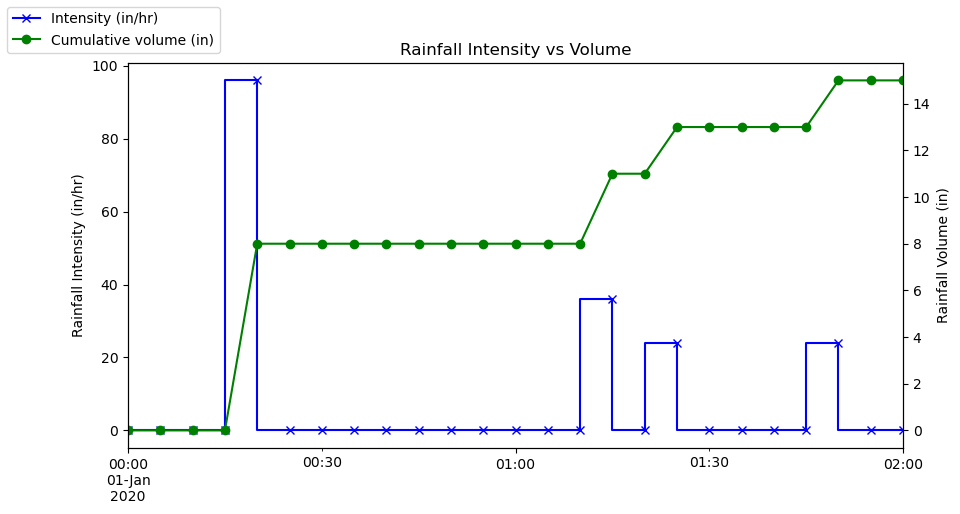

In [20]:
# plot the data
df = intensity(df)
df = cumsum(df)
rain_plot(df)


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Rainfall Intensity'}, ylabel='Rainfall Intensity (in/hr)'>)

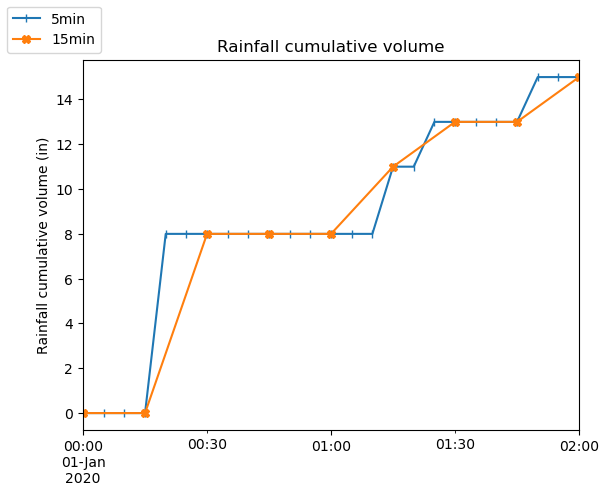

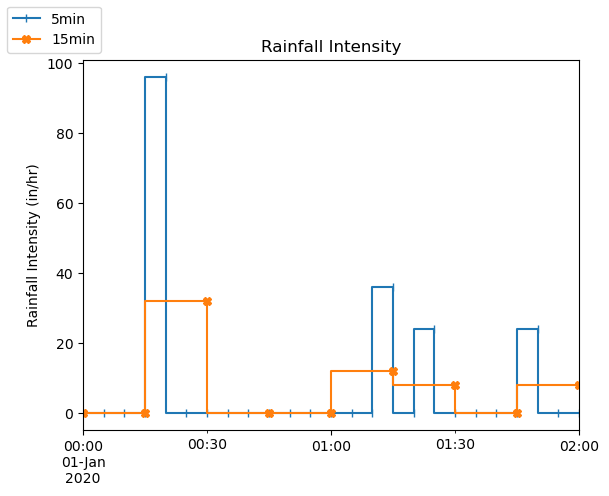

In [6]:
df_15min = resample(df, 15)
compare_cumsum([('5min', df), ('15min', df_15min)] )
compare_intensity([('5min', df), ('15min', df_15min)] )

# Irregular Time Stamp

We can randomly add a few seconds to each time stamp to show the effect of irregular time stamp.

The goal of the processing is to resample the data to 15min time interval.

In [7]:
import random
import numpy as np


In [8]:
df['ts'] = df.index
# large error
df['timestamp2'] = df.apply(lambda x: np.datetime64(x['ts']) + np.timedelta64(int(10*60*(random.random()-0.5)), 's'), axis=1)
df_vari = df.copy()
df_vari.index = df_vari['timestamp2']
df_vari = df_vari.sort_index()
# small error
df['timestamp2'] = df.apply(lambda x: np.datetime64(x['ts']) + np.timedelta64(int(2*60*(random.random()-0.5)), 's'), axis=1)
df_vari = df.copy()
df_vari.index = df_vari['timestamp2']
df_vari = df_vari.sort_index()

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Rainfall Intensity'}, xlabel='timestamp2', ylabel='Rainfall Intensity (in/hr)'>)

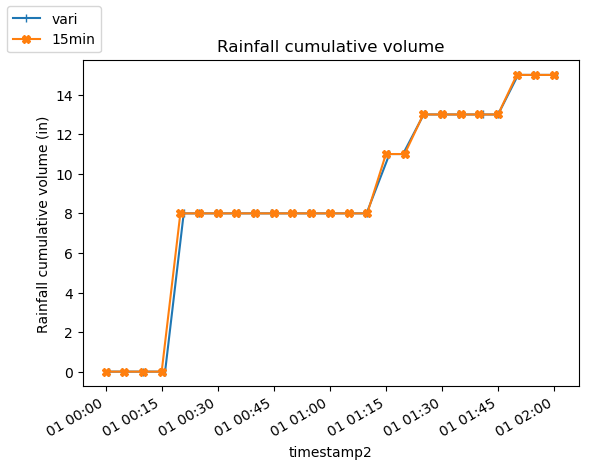

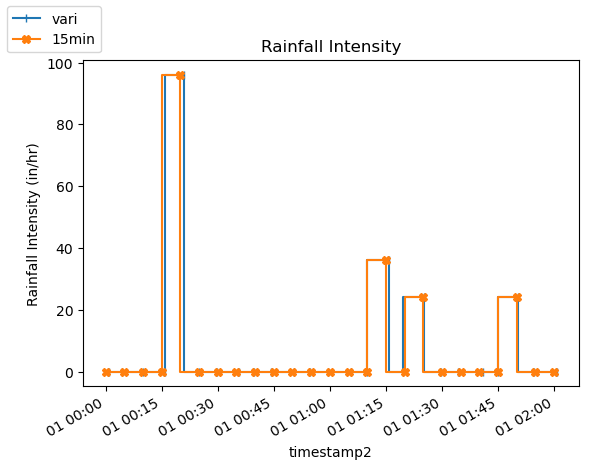

In [9]:
compare_cumsum([('vari', df_vari), ('15min', df)])
compare_intensity([('vari', df_vari), ('15min', df)])

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Rainfall Intensity'}, xlabel='timestamp2', ylabel='Rainfall Intensity (in/hr)'>)

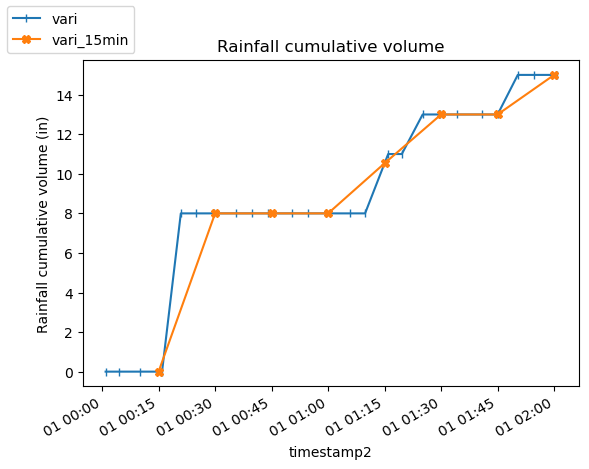

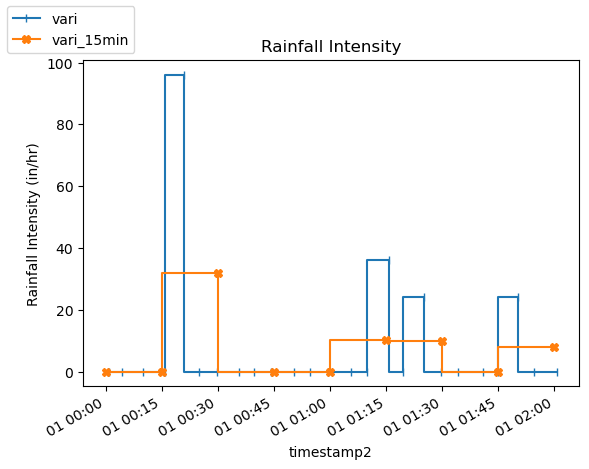

In [10]:
df2_15min = resample(df_vari, 15)
compare_cumsum([('vari', df_vari), ('vari_15min', df2_15min)])
compare_intensity([('vari', df_vari), ('vari_15min', df2_15min)])

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Rainfall Intensity'}, xlabel='timestamp2', ylabel='Rainfall Intensity (in/hr)'>)

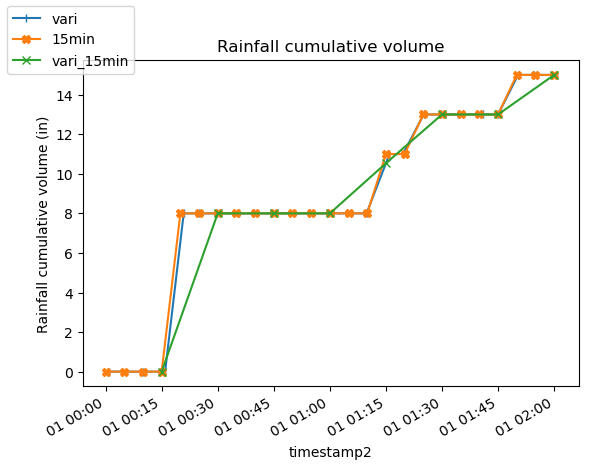

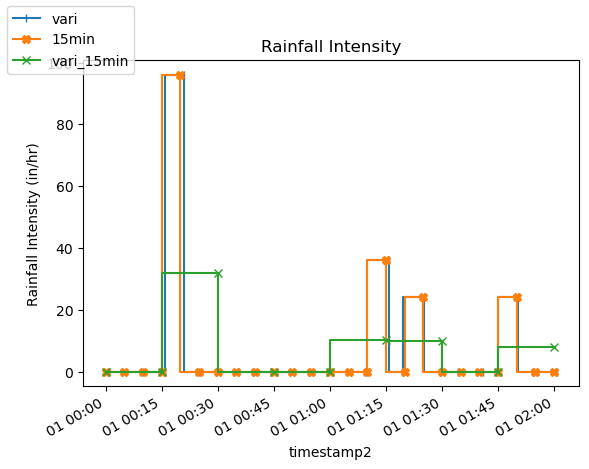

In [11]:
compare_cumsum([('vari', df_vari), ('15min', df), ('vari_15min', df2_15min)])
compare_intensity([('vari', df_vari), ('15min', df), ('vari_15min', df2_15min)])

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Rainfall Intensity'}, xlabel='timestamp2', ylabel='Rainfall Intensity (in/hr)'>)

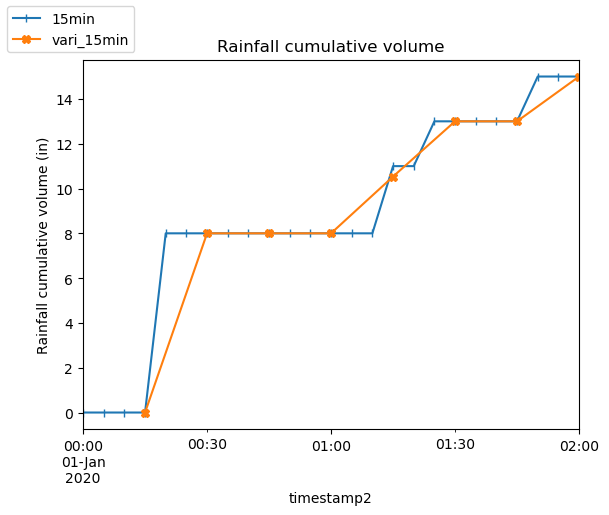

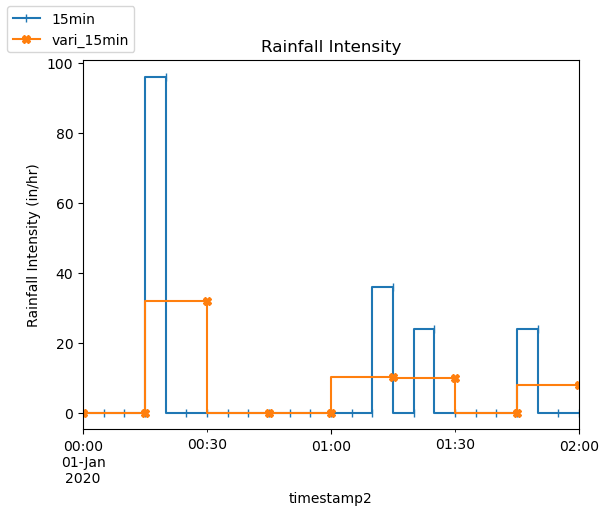

In [12]:
compare_cumsum([ ('15min', df), ('vari_15min', df2_15min)])
compare_intensity([('15min', df), ('vari_15min', df2_15min)])

# Downsampling

Assumption for resample,

* calculate duration, volume, cumsum and intensity before resampling
* index is the timestamp
 

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Rainfall Intensity'}, ylabel='Rainfall Intensity (in/hr)'>)

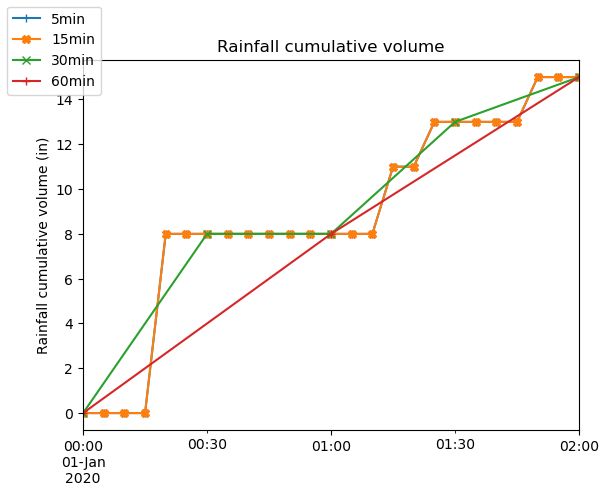

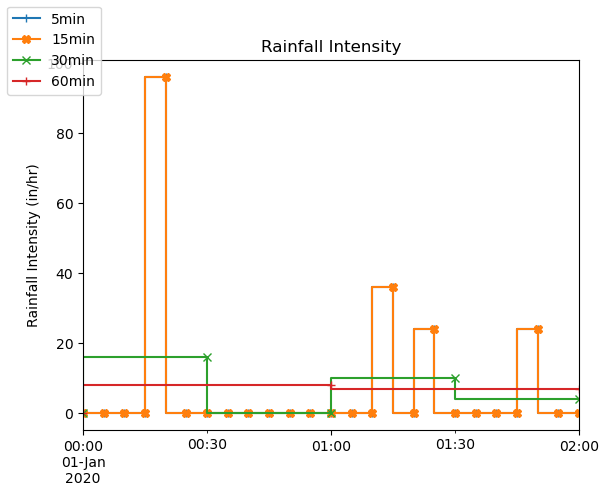

In [13]:
df_5min = resample(df, 5)
df_30min = resample(df, 30)
df_60min = resample(df, 60)
compare_cumsum([('5min', df_5min), ('15min', df), ('30min', df_30min), ('60min', df_60min)  ])
compare_intensity([('5min', df_5min), ('15min', df), ('30min', df_30min), ('60min', df_60min)  ])

## Up-Sampling

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Rainfall cumulative volume'}, ylabel='Rainfall cumulative volume (in)'>)

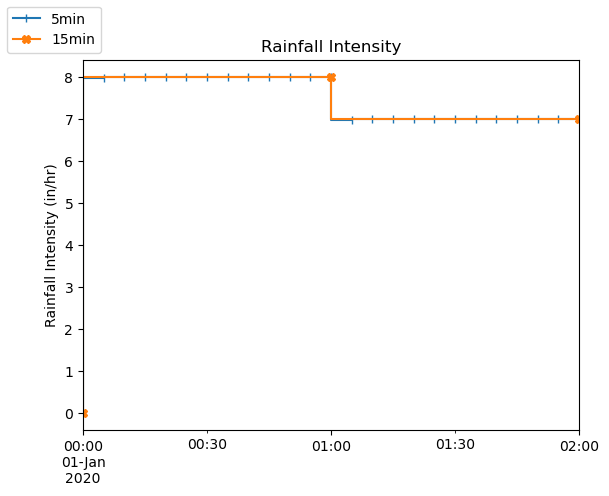

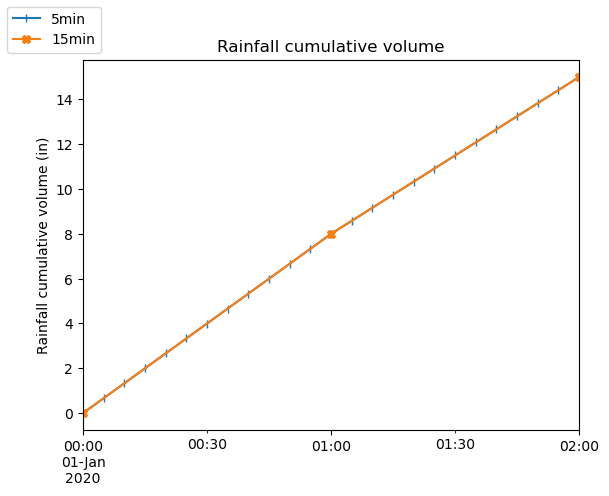

In [14]:
df2_15min = resample(df, 60)
df2_5min = resample(df2_15min, 5)
compare_intensity([('5min', df2_5min), ('15min', df2_15min)  ])
compare_cumsum([('5min', df2_5min), ('15min', df2_15min)  ])

# Read Rainfall from CSV

The following is assumed when working with rainfall data,

* _datetime: timestamp at the end of the measuring time step
* _vol: total rainfall volume measured by the end of the time step, inch
* _intensity: average rainfall intensity for the time step, in/hr
* _duration: duration of the time step, minutes

                              _datetime  _vol  _intensity  duration  _cumsum
DATETIME                                                                    
2021-05-10 00:00:00 2021-05-10 00:00:00   0.0         0.0       0.0      0.0
2021-05-10 00:15:00 2021-05-10 00:15:00   0.0         0.0      15.0      0.0
2021-05-10 00:30:00 2021-05-10 00:30:00   0.0         0.0      15.0      0.0
2021-05-10 00:45:00 2021-05-10 00:45:00   0.0         0.0      15.0      0.0
2021-05-10 01:00:00 2021-05-10 01:00:00   0.0         0.0      15.0      0.0
                              _datetime  _vol  _intensity  duration  _cumsum
DATETIME                                                                    
2021-05-10 18:00:00 2021-05-10 18:00:00  0.00        0.00       0.0     0.00
2021-05-10 18:15:00 2021-05-10 18:15:00  0.00        0.00      15.0     0.00
2021-05-10 18:30:00 2021-05-10 18:30:00  0.01        0.04      15.0     0.01
2021-05-10 18:45:00 2021-05-10 18:45:00  0.07        0.28      15.0     0.08

(<Figure size 1000x500 with 2 Axes>,
 <AxesSubplot: title={'center': 'Rainfall Intensity vs Volume'}, xlabel='DATETIME', ylabel='Rainfall Intensity (in/hr)'>)

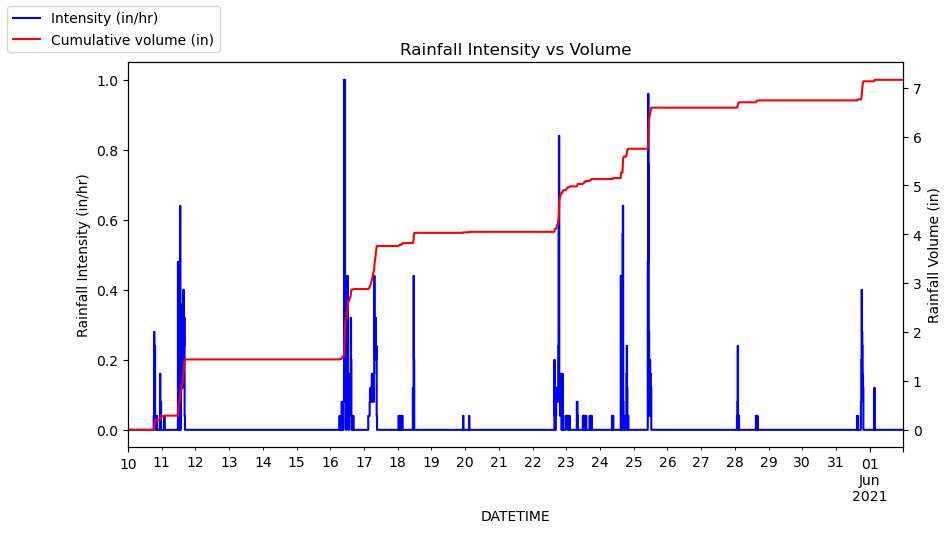

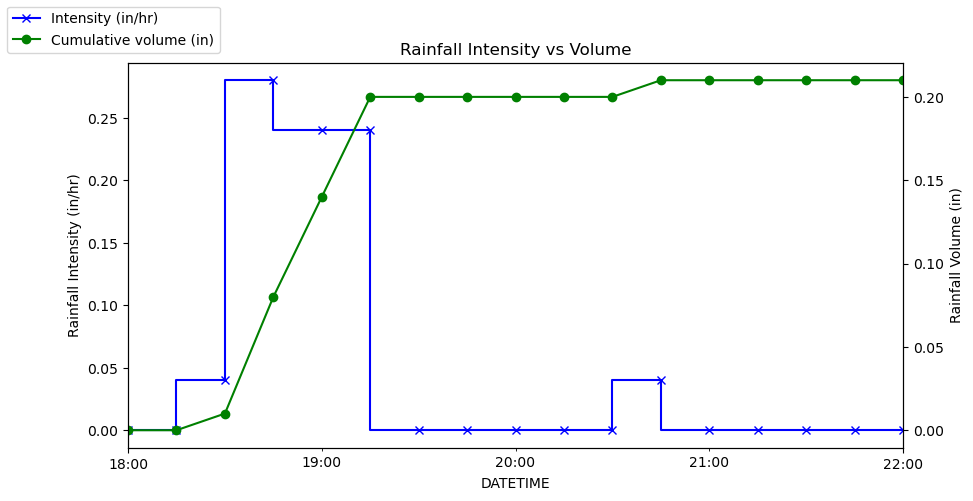

In [15]:
csv_path = './data/RG2.csv'
datetime_fld = 'DATETIME'
value_field = 'RAINFALL_IN'
value_type = 'in'
df = read_rainfall(csv_path, datetime_fld, value_field, value_type)
df = intensity(df)
df = cumsum(df)
print(df.head())
rain_plot(df, int_style='b-', vol_style='r-')
df = df.loc['2021-05-10 18:00':'2021-05-10 22:00',]
df = intensity(df)
df = cumsum(df)
print(df.head())
rain_plot(df)